In [66]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from itertools import product
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from itertools import chain
import scipy.stats as stats
import warnings
from functools import reduce
import math

In [23]:
df_train = pd.read_csv("./adult.data", header=None)
df_test = pd.read_csv("./adult.test", header=None)

In [24]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [26]:
df_train.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "salary"]
df_test.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "salary"]

In [27]:
df = pd.concat([df_train, df_test])

In [29]:
X = df.drop(["salary"], axis=1)

In [31]:
y = df.salary

In [32]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


## Utils

In [6]:
def analyze_categorical_variables(data):
    """
    Analyzes categorical variables in a DataFrame.

    Args:
        data (DataFrame): The DataFrame containing the data.

    Returns:
        dict: A dictionary where the different categories, their absolute frequencies,
              and relative frequencies are stored.
    """
    # Initialize a dictionary to store the results
    results = {}

    # Generate a list of the variable names
    variables = list(data.columns)

    # Select the numerical columns in the DataFrame
    numerical = data.select_dtypes(include=['int', 'int32', 'int64', 'float', 'float32', 'float64']).columns

    # Select the categorical columns in the DataFrame
    categorical = [variable for variable in variables if variable not in numerical]

    # Iterate through the categorical variables
    for category in categorical:
        # Check if the categorical variable exists in the DataFrame
        if category in data.columns:
            # Create a summary DataFrame for the categorical variable
            summary = pd.DataFrame({
                'n': data[category].value_counts(),                # Count of frequencies
                '%': data[category].value_counts(normalize=True)  # Percentage of frequencies
            })
            results[category] = summary  # Store the summary in the dictionary
        else:
            # If the variable does not exist in the data, store None in the dictionary
            results[category] = None

    return results

In [7]:
def count_unique_values(data):
    """
    Counts unique values in each numeric variable of a DataFrame.

    Args:
        data (DataFrame): The DataFrame containing the data.

    Returns:
        DataFrame: A DataFrame with the variables and the number of unique values in each.
    """
    # Select the numerical columns in the DataFrame
    numerical = data.select_dtypes(include=['int', 'int32', 'int64', 'float', 'float32', 'float64'])

    # Calculate the number of unique values in each numerical column
    results = numerical.apply(lambda x: len(x.unique()))

    # Create a DataFrame with the results
    result = pd.DataFrame({'Column': results.index, 'Unique': results.values})

    return result


In [45]:
def freq_numeric_variables(data, numeric_as_categorical):
    """
    Calculates the frequencies of different values of numeric variables (treated as categorical).
    
    Args:
        data: DataFrame containing the data.
        numeric_as_categorical: List of names of numeric variables to analyze.
    
    Returns:
        dict: A dictionary where the keys are the names of the numeric variables and the values are 
              DataFrames with the summary of frequencies and percentages.
    """
    results = {}

    for variable in numeric_as_categorical:
        # Check if the variable exists in the DataFrame
        if variable in data.columns:
            # Create a summary DataFrame for the variable
            summary = pd.DataFrame({
                'n': data[variable].value_counts(),               # Frequency count
                '%': data[variable].value_counts(normalize=True) # Percentage frequency
            })
            results[variable] = summary  # Store the summary in the dictionary
        else:
            # If the variable doesn't exist in the data, store None in the dictionary
            results[variable] = None

    return results


In [63]:
def missing_pattern(data_input):
    """
    Visualizes a heatmap showing the correlation matrix of missing values in the dataset.

    Args:
        data_input (DataFrame): The input dataset.
    """
    # Calculate a correlation matrix of missing values for columns with at least one missing value
    correlation_matrix = data_input[data_input.columns[data_input.isna().sum() > 0]].isna().corr()
    
    # Create a mask to hide the upper triangle of the matrix (symmetry)
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Set the figure size and font scale for the plot
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=0.6)
    
    # Generate a heatmap of the missing value correlation matrix
    # 'annot=True' shows the values inside the cells
    # 'cmap="coolwarm"' sets the color palette for the heatmap
    # 'fmt=".2f"' formats the values as floats with two decimal places
    # 'cbar=True' shows the color bar (scale) on the right
    # 'mask=mask' applies the mask to hide the upper triangle
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, mask=mask)
    
    # Set the plot title
    plt.title("Correlation matrix of missing values")
    plt.show()


In [47]:
cat_var = ["workclass", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "native_country"]
cont_var = ["age", "fnlwgt", "capital_gain", "capital_loss", "hours_per_week"]

In [40]:
categorical = analyze_categorical_variables(X)
for key in categorical:
    print(key)
    print(categorical[key])
    print("\n")

workclass
                      n         %
workclass                        
Private           33906  0.694198
Self-emp-not-inc   3862  0.079071
Local-gov          3136  0.064207
?                  2799  0.057307
State-gov          1981  0.040559
Self-emp-inc       1695  0.034704
Federal-gov        1432  0.029319
Without-pay          21  0.000430
Never-worked         10  0.000205


education
                  n         %
education                    
HS-grad       15784  0.323164
Some-college  10878  0.222718
Bachelors      8025  0.164305
Masters        2657  0.054400
Assoc-voc      2061  0.042197
11th           1812  0.037099
Assoc-acdm     1601  0.032779
10th           1389  0.028439
7th-8th         955  0.019553
Prof-school     834  0.017075
9th             756  0.015478
12th            657  0.013452
Doctorate       594  0.012162
5th-6th         509  0.010421
1st-4th         247  0.005057
Preschool        83  0.001699


marital-status
                           n         %
marital-

A lot of categories are unblanced. It is necessary to regroup some variables according to more general entities

In [43]:
display(count_unique_values(X))
print(X.shape)

,Column,Unique
0,age,74
1,fnlwgt,28523
2,education-num,16
3,capital_gain,123
4,capital_loss,99
5,hours_per_week,96


(48842, 14)


fnlwgt is a socioeconomic variable. Having this variable in the analysis will greatly improve the results but we won't get the intricacies of the data

In [48]:
freq_numeric_variables(X, cont_var)

{'age':         n         %
 age                
 36   1348  0.027599
 35   1337  0.027374
 33   1335  0.027333
 23   1329  0.027210
 31   1325  0.027128
 ..    ...       ...
 88      6  0.000123
 85      5  0.000102
 87      3  0.000061
 89      2  0.000041
 86      1  0.000020
 
 [74 rows x 2 columns],
 'fnlwgt':          n         %
 fnlwgt              
 203488  21  0.000430
 120277  19  0.000389
 190290  19  0.000389
 126569  18  0.000369
 125892  18  0.000369
 ...     ..       ...
 374763   1  0.000020
 242136   1  0.000020
 26711    1  0.000020
 117909   1  0.000020
 159691   1  0.000020
 
 [28523 rows x 2 columns],
 'capital_gain':                   n         %
 capital_gain                 
 0             44807  0.917387
 15024           513  0.010503
 7688            410  0.008394
 7298            364  0.007453
 99999           244  0.004996
 ...             ...       ...
 2387              1  0.000020
 1111              1  0.000020
 7262              1  0.000020
 1731       

All variables should be categories, as they do not represent data consistently

Now we will replace '?' by NA so we can analyse missing data:

In [61]:
X.replace('?', np.nan, inplace=True)
X.replace(' ?', np.nan, inplace=True)

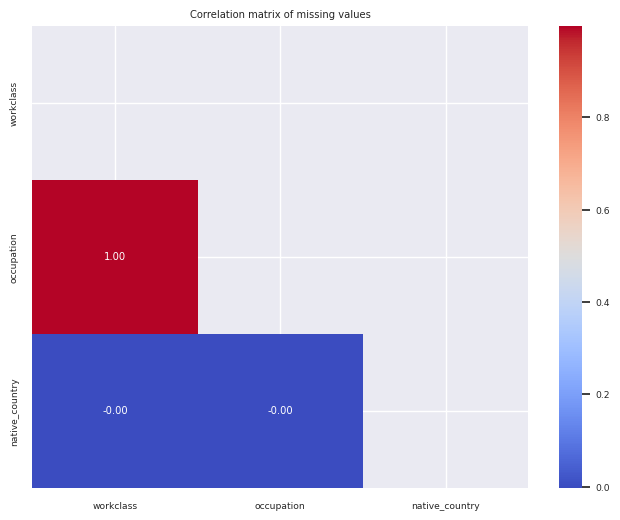

In [69]:
missing_pattern(X)